# Overview of ideas

There are several topics and problems here.

## Virtual Patients

We are solving this problem by applying DP to GP. We take the distribution of data and calculate the GP mean function (for example) then perterb it using a sample from the same GP's kernel.

We will need to use inducing inputs for two reasons:

1. It will allow the points to be spaced sufficiently far apart to ensure that bounds we chose for the noise remain valid.
2. It means that the sensitivity of the movement of individual data will be limited. For example if a point is moved across the whole input domain, the effect on the inducing inputs will be small.

The next step is to bound this change. We need to do this in two ways:

1. How much can the inducing inputs move in the 'most common cases'
2. How likely is it that this is not one of the 'most common cases' (this allows us to use the $\delta$ parameter within the DP definition).
    
## User-centric data and a distributed learning platform

We want to keep user data on the user device (or on a cloud service that only they have the decryption key to).

We want to train a GP on anonymous data from many users.

We might want to do further training locally?

### Ways to anonymise?

#### Differential Privacy

use the local model: Add enough noise so that individual rows can be released

#### Differential Privacy with Multiparty computation

DP benefits from aggregation (less noise is required, e.g. for the mean of a variable). Multiparty computation requires a large number of messages to be passed, that increases quickly with the number of parties. Maybe a compromise can be found between the two (group people into subgroups, each of which has MPC used within it to produce a noisy output, then these outputs are combined).

Example:

1 million people want to find the mean of their incomes. Let's assume they vary between 0 and £100,000.

MPC could anonymously find this value (and then add noise proportional to 100,000/1,000,000 = 0.1).

This will require 1 million message passes.

Alternatively:

We could split the million people into 10,000 groups. Each will message pass 100 times. The noise added to each mean estimate will be 100,000/100 = 1000. We have 10,000 groups, so our estimate error will be 1000/sqrt(10,000) = 1000/100 = 10. So 100 times more noise, but it would take 10,000 less time.

I don't know anything about MPC but it seems that usually the message count scales quickly with N - not just O(N). I'll look for a more concrete example.

I don't know if MPC is ever practial. It requires communication between users... or their data stores.

#### Differential Privacy over Parameters

This is related to the work from Temo.

If multiple people are sent queries for the sum of subsets of parameters, the space for the centralised machine learner will consist of lots of planes passing at 45 degrees from sets of axes. A zero-mean prior will help resolve these. With enough of them could the learner make inference about the whole dataset?



## How much computation can happen locally?

To reason about this problem I feel an example is useful.

Consider if we speak to myfitnesspal and suggest a button be added to allow migraine suffers to report when they have a migraine. One could then figure out what foods are triggers.

    Migraine:  |           |  | |             |
    Foods:   a b c  a    b  c  b b  b b a   b a  
    
    Migraine:     | |     |     |     |    |   
    Foods:     c c  c d  ca     a a  a   b
    
    Migraine:     |                    | |      
    Foods:    c d    b                 d b  a 
    
    Migraine:                    |     || |   
    Foods:    c   d    c   d   a  b     a b  c
     
A tempting start might be a GLM or (obviously) a GP.

Maybe we would start by looking for likely links between different foods; some people who are affected by food 'a' are also affected by food 'c'? Each of these could be done locally. In the case of the GLM a weight matrix would be output, the weights could be protected using standard Differential Privacy (local model). At the server the weight matrices could be combined, e.g. finding which weights are often correlated (can this be done if we've added DP local-model noise?). This info can be returned to the users, who can use the refined weight matrices to help increase the guess of their own triggers.

How would this be done with GPs? Never mind - just use the GLM.
    
    
# To Do

 - Read http://papers.nips.cc/paper/5392-extremal-mechanisms-for-local-differential-privacy

# Local Computation: The migraine example

## 1. Simple GLM to find triggers (one person)

Below we just have a toy set of data, which we then use a GLM on to recover the causes of the migraine (by individual).

I'm currently unclear how combining multiple people can help predict an individual's migraine sources.

In [254]:
npeople = 100
nfood = 10
ndays = 365
import numpy as np

triggers = 1.0*(np.random.rand(npeople,nfood)<0.2)

#for i in range(10):
#    fooda = np.random.randint(nfood)
#    foodb = np.random.randint(nfood)
#    foodc = np.random.randint(nfood)
#    triggers[:,fooda] += triggers[:,foodc]*1
#    triggers[:,foodb] -= triggers[:,foodc]*1
#    triggers = triggers/np.max(triggers)

triggers = triggers/np.max(triggers)
for i in range(3):
    triggers[:,i+1] += triggers[:,i]
triggers = triggers/np.max(triggers)

triggers = triggers/np.max(triggers) * np.random.rand(npeople,nfood)
%precision 2

#print triggers

#code to try to make it randomly
#cov = np.random.rand(nfood,nfood)+np.eye(nfood)
#cov = cov * cov.T
#print cov
#triggers = np.random.multivariate_normal(np.ones(nfood)*0.5,cov, npeople)
#triggers = triggers / np.max(triggers)
#triggers[triggers<0] = 0
#print triggers

personbackgroundrisk = np.random.rand(npeople)*0.03
diary = np.zeros((npeople,nfood,ndays))
migraine = np.zeros((npeople,ndays))
for person in range(npeople):
    for day in range(ndays):        
        for food in range(nfood):
            if (np.random.rand()<0.05):
                diary[person,food,day] = 1.0
        p = np.dot(diary[person,:,day],triggers[person,:])
        p = p + personbackgroundrisk[person]
        if p>1:
            p = 1
        migraine[person,day] = 1*(np.random.rand()<p)

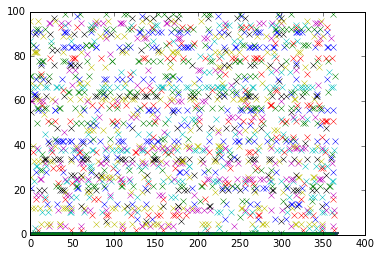

In [255]:
import matplotlib.pyplot as plt
%matplotlib inline
for p in range(npeople):
    plt.plot(migraine[p,:].transpose()*p,'x')

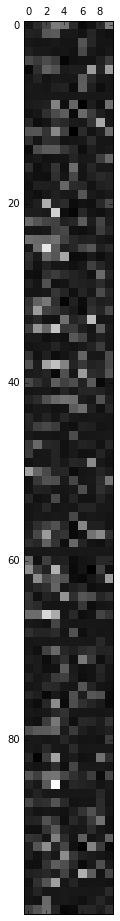

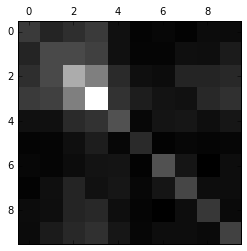

In [256]:
temp = np.zeros((npeople,nfood))
for person in range(npeople):
    A = diary[person,:,:].transpose()
    y = migraine[person,:]
    m = np.linalg.lstsq(A, y)[0]
    %precision 2
    #print m #guess
    temp[person,:] = m
    #print triggers[0,:] #actual
    #plt.matshow(diary[0,:,:].transpose(), cmap='gray');
plt.matshow(temp,cmap='gray')
plt.matshow(np.dot(temp.T,temp),cmap='gray')

<Container object of 3 artists>

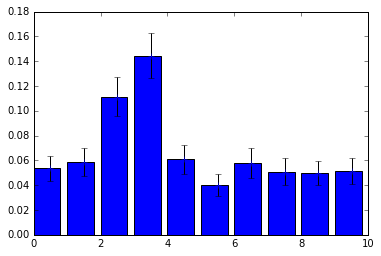

In [257]:
plt.bar(range(nfood),np.mean(temp,0))
plt.errorbar(np.array(range(nfood))+.5,np.mean(temp,0),np.std(temp,0)/np.sqrt(npeople),ecolor='k',marker='+',linestyle='none')

Above we used the raw parameters from the GLM. If these were made differentially private what does that mean for our estimates of the above parameters?

#### Local model

Here we just add enough noise to each of the 10 food parameters to hide the individual values.

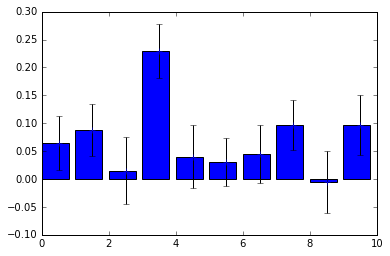

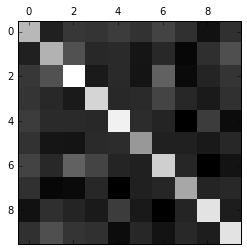

In [260]:
eps = np.log(3.0)
delta_f = 0.4
b = delta_f / eps
noisy_temp = temp + np.random.laplace(0,b,temp.shape)

plt.bar(range(nfood),np.mean(noisy_temp,0))
plt.errorbar(np.array(range(nfood))+.5,np.mean(noisy_temp,0),np.std(noisy_temp,0)/np.sqrt(npeople),ecolor='k',marker='+',linestyle='none')

plt.matshow(np.dot(noisy_temp.T,noisy_temp),cmap='gray')

Although we still know roughly which factors are most relevant, we've lost the correlation structure.

The idea is that the server queries subsets of the foods from each user,...

In [263]:
b = delta_f*2 / eps
np.sum(temp[:,[0,1,2,3]],1) + np.random.laplace(0,b,temp.shape)

array([ 0.6 ,  0.54, -0.02,  0.02,  0.62,  0.5 ,  0.02,  0.03,  0.  ,
        0.44,  0.24,  0.09,  0.95,  0.24,  0.63, -0.05,  0.14,  0.01,
        0.05, -0.02,  0.6 ,  0.71,  0.83,  0.13,  1.22,  1.3 ,  0.62,
        0.07,  0.16,  0.2 ,  0.08,  0.79,  0.86,  0.03,  1.48, -0.03,
        0.02,  0.07,  1.34,  0.01,  0.54, -0.03,  0.61, -0.04,  0.08,
        0.49, -0.03,  0.5 ,  0.17,  0.02,  1.  ,  0.5 ,  0.04,  0.19,
        0.02, -0.01,  0.44,  0.76,  0.49,  0.  ,  0.44,  1.15,  0.89,
        0.45,  0.12,  0.14,  1.85,  0.13,  0.24, -0.01,  0.41,  0.02,
       -0.05,  0.17,  0.12,  0.02,  0.42,  0.04,  0.43,  0.95, -0.01,
        0.05,  0.62,  0.06,  1.02,  1.12,  0.03,  0.54, -0.01,  0.39,
        0.28,  0.56,  0.72,  0.05,  0.28,  0.14,  0.79,  0.02,  0.26,  0.71])

# Differential Privacy over Parameters

> If multiple people are sent queries for the sum of subsets of parameters, the space for the centralised machine learner will consist of lots of planes passing at 45 degrees from sets of axes. A zero-mean prior will help resolve these. With enough of them could the learner make inference about the whole dataset?
